<a href="https://colab.research.google.com/github/coldfir3/FastAI-Demos/blob/main/Resize%20Learning%20Dataloader%20(WIP).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from fastai.vision.all import *

In [2]:
path = untar_data(URLs.FLOWERS)

In [3]:
path.ls()

(#4) [Path('/home/passos/.fastai/data/oxford-102-flowers/test.txt'),Path('/home/passos/.fastai/data/oxford-102-flowers/jpg'),Path('/home/passos/.fastai/data/oxford-102-flowers/train.txt'),Path('/home/passos/.fastai/data/oxford-102-flowers/valid.txt')]

In [4]:
(path/'jpg').ls()

(#8189) [Path('/home/passos/.fastai/data/oxford-102-flowers/jpg/image_06774.jpg'),Path('/home/passos/.fastai/data/oxford-102-flowers/jpg/image_05618.jpg'),Path('/home/passos/.fastai/data/oxford-102-flowers/jpg/image_07688.jpg'),Path('/home/passos/.fastai/data/oxford-102-flowers/jpg/image_00489.jpg'),Path('/home/passos/.fastai/data/oxford-102-flowers/jpg/image_07698.jpg'),Path('/home/passos/.fastai/data/oxford-102-flowers/jpg/image_00485.jpg'),Path('/home/passos/.fastai/data/oxford-102-flowers/jpg/image_02364.jpg'),Path('/home/passos/.fastai/data/oxford-102-flowers/jpg/image_04158.jpg'),Path('/home/passos/.fastai/data/oxford-102-flowers/jpg/image_04626.jpg'),Path('/home/passos/.fastai/data/oxford-102-flowers/jpg/image_03046.jpg')...]

In [5]:
train_df = pd.concat([
            pd.read_csv(path/'train.txt', sep=' ', header=None, names=['path', 'class']),
            pd.read_csv(path/'test.txt', sep=' ', header=None, names=['path', 'class'])]).sample(frac=1).reset_index(drop=True)
train_df['is_valid'] = False
valid_df = pd.read_csv(path/'valid.txt', sep=' ', header=None, names=['path', 'class'])
valid_df['is_valid'] = True
df = pd.concat([train_df, valid_df]).sample(frac=1).reset_index(drop=True)

## Baseline pipeline

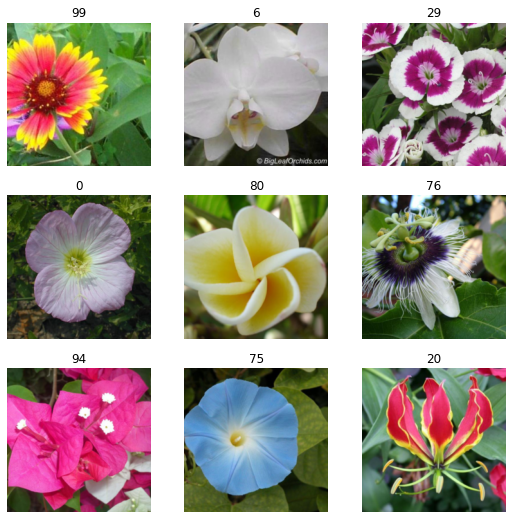

In [6]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    splitter=ColSplitter(),
    get_x=ColReader('path', pref=path),
    get_y=ColReader('class'),
    item_tfms=Resize(224)    
).dataloaders(df, bs = 32, num_workers = 8)
dls.show_batch()

In [7]:
learn = cnn_learner(dls, resnet18, metrics = accuracy)
learn.fine_tune(1)

epoch,train_loss,valid_loss,accuracy,time
0,1.711279,0.671091,0.839216,00:10


epoch,train_loss,valid_loss,accuracy,time
0,0.511341,0.292436,0.918627,00:12


## Resize Learning

In [8]:
# https://arxiv.org/pdf/2103.09950.pdf
# https://github.com/yundaehyuck/Learning-to-resize-images-for-computer-vision-tasks/blob/main/resizing_network.ipynb

class ResBlock(nn.Module):
    def __init__(self,num_channels=16):
        super(ResBlock,self).__init__()
        
        self.conv1 = nn.Conv2d(num_channels,num_channels,kernel_size=3,stride=1,padding=1)
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.leakyrelu = nn.LeakyReLU(negative_slope=0.2,inplace=True)
        
        self.conv2 = nn.Conv2d(num_channels,num_channels,kernel_size=3,stride=1,padding=1)
        self.bn2 = nn.BatchNorm2d(num_channels)
    
    def forward(self,x):
        residual = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        
        out = self.leakyrelu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        
        return out

def make_block(r,n):
    residual = []
    
    for i in range(r):
        block = ResBlock(num_channels=n)
        residual.append(block)
    
    return nn.Sequential(*residual)

class ResizingNetwork(nn.Module):
    def __init__(self, img_size, in_chans = 3, r=1, n=16):
        super(ResizingNetwork, self).__init__()

        self.img_size = img_size
        
        self.conv1 = nn.Conv2d(in_channels=in_chans,out_channels=n,kernel_size=7,stride=1,padding=3)
        self.leakyrelu1 = nn.LeakyReLU(negative_slope=0.2,inplace=True)
        
        self.conv2 = nn.Conv2d(n,n,kernel_size=1,stride=1)
        self.leakyrelu2 = nn.LeakyReLU(negative_slope=0.2,inplace=True)
        self.bn1 = nn.BatchNorm2d(n)
                
        self.resblock = make_block(r,n)        
        
        self.conv3 = nn.Conv2d(n,n,kernel_size=3,stride=1,padding=1)
        self.bn2 = nn.BatchNorm2d(n)
        
        self.conv4 = nn.Conv2d(n,out_channels=in_chans,kernel_size=7,stride=1,padding=3)

    def forward(self, x):
       
        residual = F.interpolate(x, size=(self.img_size, self.img_size), mode='bilinear', align_corners=False)
        
        out = self.conv1(x)
        out = self.leakyrelu1(out)
        
        out = self.conv2(out)
        out = self.leakyrelu2(out)
        out = self.bn1(out)
        
        out_residual = F.interpolate(out, size=(self.img_size, self.img_size), mode='bilinear', align_corners=False)
        
        out = self.resblock(out_residual)
        
        out = self.conv3(out)
        out = self.bn2(out)
        out += out_residual
        
        out = self.conv4(out)
        out += residual

        return out

class ResizeNet(Transform):
    def __init__(self, size):
        self.resize = ResizingNetwork(size)

    def encodes(self, x:PILImage):

        # print('here')
        # print(type(x))
        # print(x.shape)

        torch.set_grad_enabled(False)

        x = ToTensor()(x)/255
        x = x.unsqueeze(0)

        torch.set_grad_enabled(True)

        x = self.resize(x)
        x = x.squeeze(0).sigmoid()

        torch.set_grad_enabled(False)

        return x

In [9]:
def BareImageBlock(cls = PILImage): return TransformBlock(type_tfms=cls.create, batch_tfms=None)

In [17]:
rn = ResizeNet(224)

In [23]:
list(rn.resize.parameters())[-1]

Parameter containing:
tensor([ 0.0028,  0.0036, -0.0188], requires_grad=True)

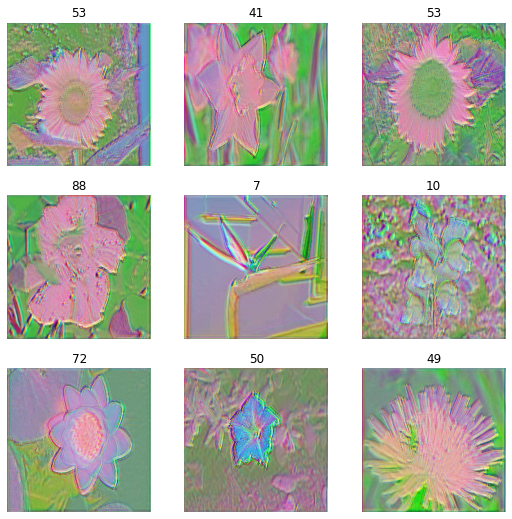

In [24]:
dls = DataBlock(
    blocks=(BareImageBlock, CategoryBlock),
    splitter=ColSplitter(),
    get_x=ColReader('path', pref=path),
    get_y=ColReader('class'),
    item_tfms=rn # Moved this out so I can see if the weights are being trained, Also, I need to save this model for inference
).dataloaders(df, bs = 32, num_workers = 8)
dls.show_batch()

In [25]:
class re_enable_grad(Callback):
    def before_batch(self):
        torch.set_grad_enabled(True)

In [26]:
learn = cnn_learner(dls, resnet18, metrics = accuracy, cbs = re_enable_grad())
learn.fine_tune(1)

epoch,train_loss,valid_loss,accuracy,time
0,2.508204,1.370064,0.653922,02:11


epoch,train_loss,valid_loss,accuracy,time
0,0.952491,0.768199,0.794118,02:10


In [27]:
list(rn.resize.parameters())[-1] ## Not training

Parameter containing:
tensor([ 0.0028,  0.0036, -0.0188], requires_grad=True)